In [1]:
!nvidia-smi

Fri Jun 11 16:45:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [121]:
!pip install tsmoothie keras-hypetune

https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/TimeSeries_Smoothing_Forecasting/TimeSeries_Smoothing_Forecasting.ipynb

In [124]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tsmoothie.smoother import *
from tsmoothie.utils_func import create_windows
from kerashypetune import KerasGridSearch

In [123]:
dataset = pd.read_csv("https://raw.githubusercontent.com/final-year-project-2021/aqi-monitoring-forecasting/main/Datasets/KolkataHourlyAQI(v4).csv", index_col=1)
dataset.index = pd.to_datetime(dataset.index)
dataset['AQI'] = dataset['AQI_calculated']
dataset.drop(["Unnamed: 0",'AQI_calculated'], axis=1, inplace=True)
dataset.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,PM10_24hr_avg,PM2.5_24hr_avg,SO2_24hr_avg,NOx_24hr_avg,NH3_24hr_avg,CO_8hr_max,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NOx_SubIndex,NH3_SubIndex,CO_SubIndex,O3_SubIndex,AQI
Datetime,,,,,,,,,,,,,,,,,,,,,,,,
2018-04-10 10:00:00,34.82,54.45,3.89,51.45,28.900,9.620,1.13,5.98,41.210,NaN,NaN,NaN,NaN,NaN,1.13,41.210,0.0,0.0,0.0,0.0,0.0,56.5,41.210,56.0
2018-04-10 11:00:00,31.82,57.80,3.37,33.83,27.260,9.205,1.02,10.99,50.440,NaN,NaN,NaN,NaN,NaN,1.13,50.440,0.0,0.0,0.0,0.0,0.0,56.5,50.440,56.0
2018-04-10 12:00:00,29.61,51.04,2.97,16.60,27.665,9.680,0.94,8.16,60.530,NaN,NaN,NaN,NaN,NaN,1.13,60.530,0.0,0.0,0.0,0.0,0.0,56.5,60.530,61.0
2018-04-10 13:00:00,33.37,51.61,2.78,18.79,26.415,9.550,0.91,6.62,62.625,NaN,NaN,NaN,NaN,NaN,1.13,62.625,0.0,0.0,0.0,0.0,0.0,56.5,62.625,63.0
2018-04-10 14:00:00,36.71,58.00,2.62,23.19,26.830,9.450,0.91,6.80,67.930,NaN,NaN,NaN,NaN,NaN,1.13,67.930,0.0,0.0,0.0,0.0,0.0,56.5,67.930,68.0


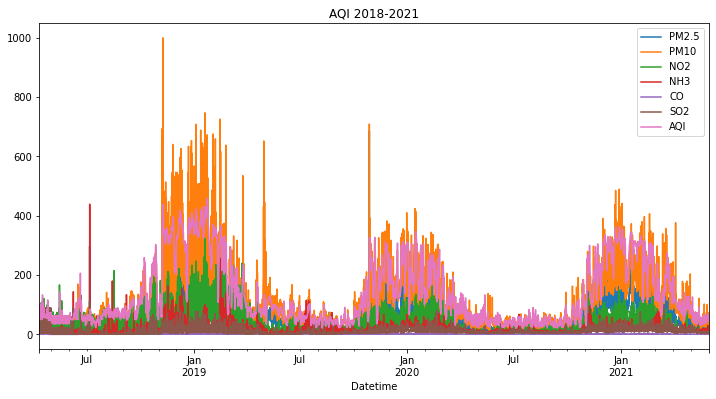

In [5]:
plt.figure(figsize=(12,6))
plt.title("AQI 2018-2021")

dataset['PM2.5'].plot()
dataset['PM10'].plot()
dataset['NO2'].plot()
dataset['NH3'].plot()
dataset['CO'].plot()
dataset['SO2'].plot()
dataset['AQI'].plot()
plt.legend()


In [6]:
columns = dataset.columns
columns[1:]

Index(['PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'PM10_24hr_avg',
       'PM2.5_24hr_avg', 'SO2_24hr_avg', 'NOx_24hr_avg', 'NH3_24hr_avg',
       'CO_8hr_max', 'O3_8hr_max', 'PM2.5_SubIndex', 'PM10_SubIndex',
       'SO2_SubIndex', 'NOx_SubIndex', 'NH3_SubIndex', 'CO_SubIndex',
       'O3_SubIndex', 'AQI'],
      dtype='object')

In [7]:
columns = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'AQI']
dataset = dataset[columns]
dataset.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI
Datetime,,,,,,,,,,
2018-04-10 10:00:00,34.82,54.45,3.89,51.45,28.900,9.620,1.13,5.98,41.210,56.0
2018-04-10 11:00:00,31.82,57.80,3.37,33.83,27.260,9.205,1.02,10.99,50.440,56.0
2018-04-10 12:00:00,29.61,51.04,2.97,16.60,27.665,9.680,0.94,8.16,60.530,61.0
2018-04-10 13:00:00,33.37,51.61,2.78,18.79,26.415,9.550,0.91,6.62,62.625,63.0
2018-04-10 14:00:00,36.71,58.00,2.62,23.19,26.830,9.450,0.91,6.80,67.930,68.0


In [8]:
dataset.shape

(27542, 10)

In [9]:
smoother = KalmanSmoother(component='level_longseason', 
                          component_noise={'level':0.1, 'longseason':0.1}, 
                          n_longseasons=365*24)
smoother.smooth(dataset[columns].T)

<tsmoothie.smoother.KalmanSmoother>

In [10]:
smoother.smooth_data.T.shape

(27542, 10)

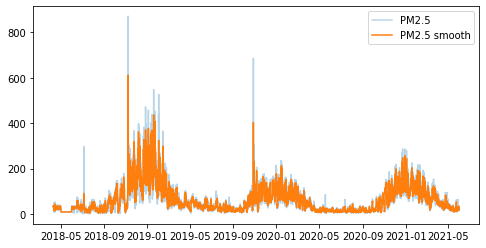

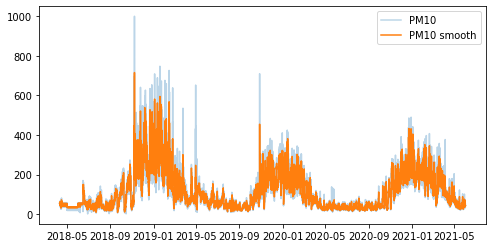

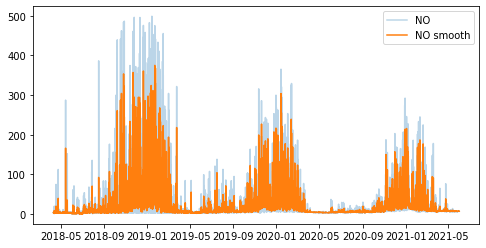

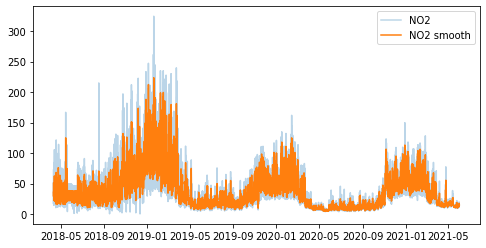

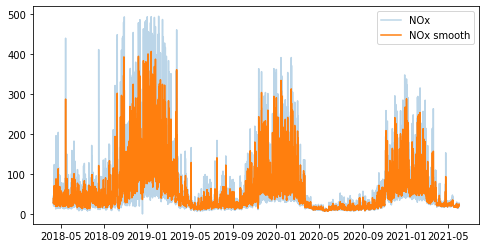

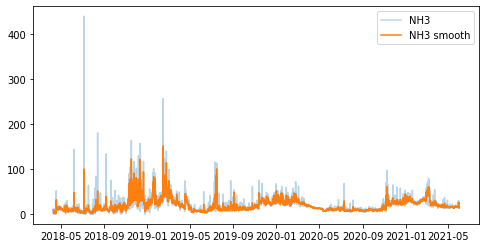

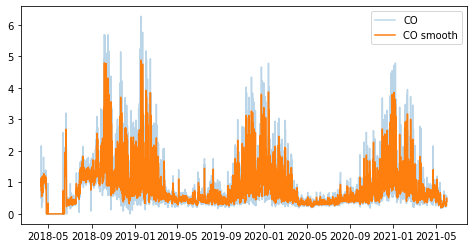

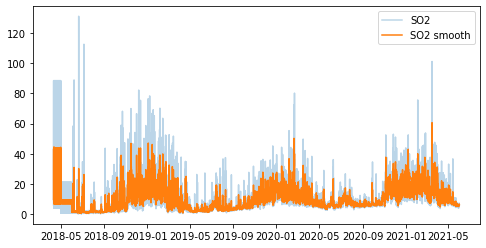

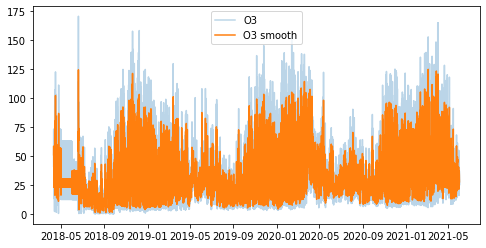

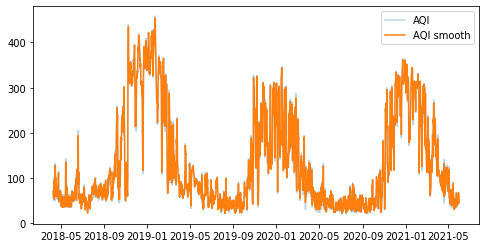

In [11]:
for i,name in enumerate(dataset.columns):
    
    plt.figure(figsize=(8,4))
    plt.plot(dataset.index, smoother.data[i], label=name, alpha=0.3)
    plt.plot(dataset.index, smoother.smooth_data[i], label=name+' smooth')
    plt.legend(); plt.show()

In [12]:
filteredData = dataset.copy()
for i,name in enumerate(dataset.columns):
    filteredData[name] = smoother.smooth_data[i]

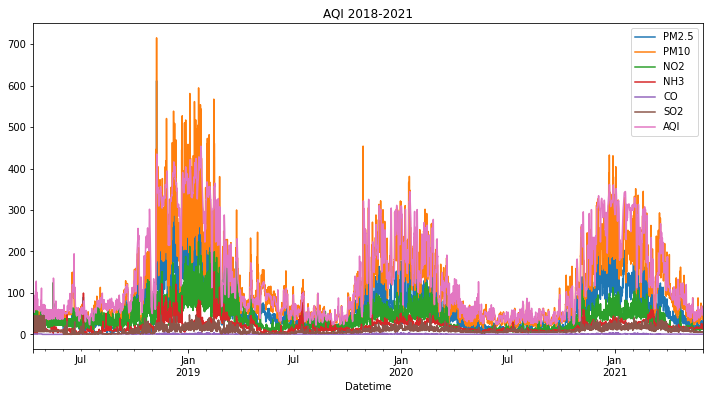

In [13]:
plt.figure(figsize=(12,6))
plt.title("AQI 2018-2021")

filteredData['PM2.5'].plot()
filteredData['PM10'].plot()
filteredData['NO2'].plot()
filteredData['NH3'].plot()
filteredData['CO'].plot()
filteredData['SO2'].plot()
filteredData['AQI'].plot()
plt.legend()


In [14]:
dataTrain, dataVal = train_test_split(filteredData, test_size=0.18, shuffle=False)
dataTrain.shape, dataVal.shape

((22584, 10), (4958, 10))

In [15]:
scalerX = StandardScaler()
scalerY = StandardScaler()

#scalerX = MinMaxScaler()
#scalerY = MinMaxScaler()

#scalerX = RobustScaler()
#scalerY = RobustScaler()

scalerX.fit(dataTrain[columns[:-1]])
scalerY.fit(dataTrain[['AQI']])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
#transformedDataset = dataset[columns].copy()

dataTrain[columns[:-1]] = scalerX.transform(dataTrain[columns[:-1]])

dataTrain[['AQI']] = scalerY.transform(dataTrain[['AQI']])

dataVal[columns[:-1]] = scalerX.transform(dataVal[columns[:-1]])

dataVal[['AQI']] = scalerY.transform(dataVal[['AQI']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

In [17]:
dataTrain.head()

,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI
Datetime,,,,,,,,,,
2018-04-10 10:00:00,-0.386655,-0.519167,-0.449080,-0.024592,-0.469359,-0.636785,0.438928,0.226993,1.109649,-0.601188
2018-04-10 11:00:00,-0.389798,-0.516919,-0.451488,-0.122737,-0.469132,-0.644911,0.404769,0.350299,1.223118,-0.591956
2018-04-10 12:00:00,-0.388702,-0.521547,-0.454743,-0.228231,-0.465171,-0.659076,0.361100,0.457121,1.365252,-0.573953
2018-04-10 13:00:00,-0.375609,-0.519336,-0.457718,-0.249658,-0.457986,-0.689511,0.327177,0.658265,1.458595,-0.553414
2018-04-10 14:00:00,-0.360726,-0.511081,-0.460164,-0.205606,-0.442122,-0.740278,0.306713,1.042634,1.499831,-0.530167


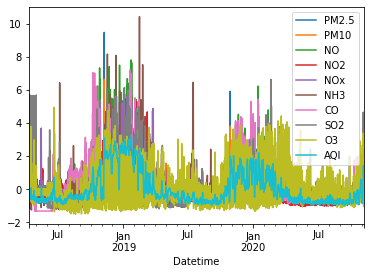

In [18]:
#dataset[columns].plot.line()
dataTrain.plot.line()

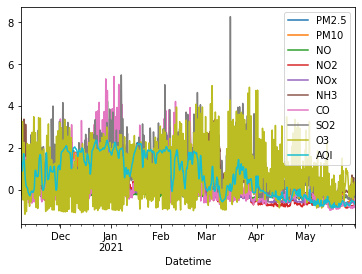

In [19]:
dataVal.plot.line()

In [ ]:
len(columns[:-1])

In [20]:
def to_supervised(data, n_input, n_out=1, stride=1):
    # flatten data
    
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data.values[in_start:in_end]            
            X.append(x_input)
            y.append(data['AQI'].values[in_end:out_end])
        # move along one time step
        in_start += stride
    return np.array(X),np.array(y)

In [21]:
n_timesteps = 15
n_features = 10
n_outputs = 3
n_stride = 1

In [22]:
X_train,y_train = to_supervised(dataTrain, n_input=n_timesteps, n_out=n_outputs, stride=n_stride)
X_val, y_val = to_supervised(dataVal, n_input=n_timesteps, n_out=n_outputs, stride=n_stride)
X_train.shape, X_val.shape,y_train.shape, y_val.shape

((22567, 15, 10), (4941, 15, 10), (22567, 3), (4941, 3))

In [23]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, RepeatVector, Input
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

def build_model(param):   
   
    model = Sequential()
    
    model.add(LSTM(param['unit'], activation=param['act'],input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(param['unit'], activation=param['act'], return_sequences=True))   
    model.add(TimeDistributed(Dense(1)))

    opt_choices = {'adam': Adam(),
                   'rms': RMSprop(),
                   'sgd': SGD()}
    
    opt = opt_choices[param['opt']]
    opt.lr = param['lr']
    model.compile(loss='mse', optimizer=opt)   
    
    return model

In [ ]:
epochs = 15
batch_size = 64
steps_per_epoch = len(X_train)//batch_size
validation_steps = len(X_val)//batch_size

In [27]:
param_grid = {
    'unit': [512, 256, 128, 64, 32], 
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'opt': ['adam','rms','sgd'],
    'epochs': 15,
    'batch_size': 256
}

In [28]:
es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = build_model

kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[es])


60 trials detected for ('unit', 'lr', 'act', 'opt', 'epochs', 'batch_size')

***** (1/60) *****
Search({'unit': 512, 'lr': 0.01, 'act': 'elu', 'opt': 'adam', 'epochs': 15, 'batch_size': 256})
SCORE: 1.71303 at epoch 5

***** (2/60) *****
Search({'unit': 512, 'lr': 0.01, 'act': 'elu', 'opt': 'rms', 'epochs': 15, 'batch_size': 256})
SCORE: 0.43617 at epoch 10

***** (3/60) *****
Search({'unit': 512, 'lr': 0.01, 'act': 'elu', 'opt': 'sgd', 'epochs': 15, 'batch_size': 256})
SCORE: 0.02827 at epoch 15

***** (4/60) *****
Search({'unit': 512, 'lr': 0.01, 'act': 'relu', 'opt': 'adam', 'epochs': 15, 'batch_size': 256})
SCORE: 0.19803 at epoch 14

***** (5/60) *****
Search({'unit': 512, 'lr': 0.01, 'act': 'relu', 'opt': 'rms', 'epochs': 15, 'batch_size': 256})
SCORE: 0.01417 at epoch 15

***** (6/60) *****
Search({'unit': 512, 'lr': 0.01, 'act': 'relu', 'opt': 'sgd', 'epochs': 15, 'batch_size': 256})
SCORE: 0.02478 at epoch 15

***** (7/60) *****
Search({'unit': 512, 'lr': 0.001, 'act': 'elu',

<kerashypetune.KerasGridSearch>

In [30]:
kgs.best_score, kgs.best_params

(0.00052,
 {'act': 'relu',
  'batch_size': 256,
  'epochs': 15,
  'lr': 0.01,
  'opt': 'adam',
  'steps_per_epoch': 89,
  'unit': 32})

In [29]:
# history = model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,
#           validation_data=(X_val, y_val), steps_per_epoch=steps_per_epoch,
#          validation_steps=validation_steps, shuffle=True)

In [ ]:
y_val.shape, X_train.shape

((4941, 3), (22567, 15, 10))

In [31]:
from sklearn.metrics import mean_squared_error
y_pred = kgs.best_model.predict(X_val)
mean_squared_error(y_val, y_pred.reshape(y_val.shape), squared=False)

0.02279338554746254

In [32]:
y_val_t = scalerY.inverse_transform(y_val)
y_pred_t = scalerY.inverse_transform(y_pred)
print("RMSE: ",mean_squared_error(y_val_t, y_pred_t.reshape(y_val.shape), squared=False))

RMSE:  2.3174327415812335


In [42]:
from pickle import dump, load
from tensorflow.keras.models import load_model

In [34]:
kgs.best_model.save("./model-v01.h5")
dump(scalerX, open('./scalerX.pkl', 'wb'))
dump(scalerY, open('./scalerY.pkl', 'wb'))
dump(smoother, open('./smoother.pkl', 'wb'))

In [35]:
X_val.shape

(4941, 15, 10)

In [119]:

scalerX = load(open("/content/scalerX.pkl","rb"))
scalerY = load(open("/content/scalerY.pkl","rb"))
smoother = load(open("/content/smoother.pkl","rb"))
model = load_model("/content/model-v01.h5")

def process_data(data):
    smoother.smooth(data.T)
    for i,name in enumerate(data.columns):
        data[name] = smoother.smooth_data[i]
    data[data.columns[:-1]] = scalerX.transform(data[data.columns[:-1]])
    data[['AQI']] = scalerY.transform(data[['AQI']])
    return data.values

def forecast_next(data: np.array):
    data = data[-15:]
    data = np.expand_dims(data, axis=0)   
    forecasts = model.predict(data)
    forecasts = scalerY.inverse_transform(forecasts)[0]   
    return forecasts.reshape(1,3)[0]

In [120]:
d = dataset[columns][50:50+15].copy()
data = process_data(d)
f = forecast_next(data)
print(f)

[63.583294 64.54561  65.86337 ]


In [114]:
dataset['AQI'].values

array([56., 56., 61., ..., 47., 46., 46.])

In [136]:
start = 40
window = 15
actuals = []
forecasts = []
for i in range(200):
    end = start+window
    d = dataset[columns][start:end].copy()
    data = process_data(d)
    actual = dataset['AQI'][end:end+3].values
    forecast = forecast_next(data)
    actuals += list(actual)
    forecasts += list(forecast)
    start += window

No handles with labels found to put in legend.


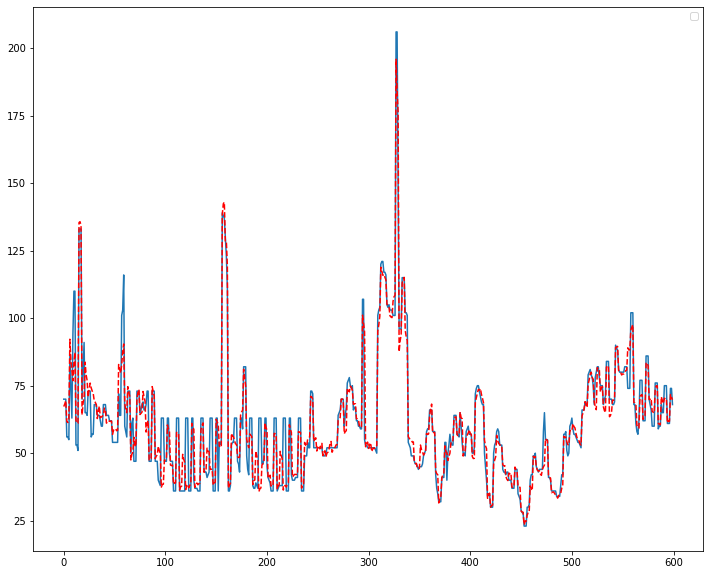

In [139]:
plt.figure(figsize=(12,10))
plt.plot(actuals)
plt.plot(forecasts, 'r--')
plt.legend()
plt.show()